## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.naive_bayes import CategoricalNB
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib import pyplot as plt
from scipy.stats import poisson
from imblearn.over_sampling import SMOTENC
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import sys
import os
sys.path.append('/content/gdrive/MyDrive/')
os.chdir('/content/gdrive/MyDrive/')

Mounted at /content/gdrive


## Retrieve data from dataset and Creating dataframe

In [ ]:
df = pd.read_csv("drt2568_2.csv")
df.head()

,No.,Month,Year,Organization,Number_Passenger
0,1,มกราคม,2564,SRT,"759,649"
1,2,มกราคม,2564,ARL,"676,101"
2,3,มกราคม,2564,MRT,"4,935,121"
3,4,มกราคม,2564,BTS,"9,391,450"
4,5,กุมภาพันธ์,2564,SRT,"797,030"


## Finding statistics

In [ ]:
df.describe()

,No.,Year
count,280.000000,280.000000
mean,140.500000,2565.807143
std,80.973247,1.199740
min,1.000000,2564.000000
25%,70.750000,2565.000000
50%,140.500000,2566.000000
75%,210.250000,2567.000000
max,280.000000,2568.000000


## Replace Thai month to English month

In [ ]:
thai_to_english_months = {
    'มกราคม': 'January',
    'กุมภาพันธ์': 'February',
    'มีนาคม': 'March',
    'เมษายน': 'April',
    'พฤษภาคม': 'May',
    'มิถุนายน': 'June',
    'กรกฎาคม': 'July',
    'สิงหาคม': 'August',
    'กันยายน': 'September',
    'ตุลาคม': 'October',
    'พฤศจิกายน': 'November',
    'ธันวาคม': 'December'
}
df['Month'] = df['Month'].replace(thai_to_english_months)
df.head()

,No.,Month,Year,Organization,Number_Passenger
0,1,January,2564,SRT,"759,649"
1,2,January,2564,ARL,"676,101"
2,3,January,2564,MRT,"4,935,121"
3,4,January,2564,BTS,"9,391,450"
4,5,February,2564,SRT,"797,030"


In [ ]:
df['Organization'].unique()

array(['SRT', 'ARL', 'MRT', 'BTS', 'RL', 'YL', 'PK'], dtype=object)

## Organization List

SRT : รถไฟสายสีแดงชานเมือง State railway of thailand

ARL : Airport rail link

MRT : Metro railway transit (รถไฟสายสีน้ำเงิน)

BTS : Green line (รถไฟฟ้าสายสีเขียว)

RL : Red line (รถไฟสายสีแดง)

YL : Yellow line (โมโนเรลสายสีเหลือง)

PK : Pink line (โมโนเรลสายสีชมพู)

## Replace month into days

In [ ]:
all_daily_rows = []

for idx, row in df.iterrows():
    month_eng = thai_to_english_months.get(row['Month'], row['Month'])
    year_ad = row['Year'] - 543  # Convert BE to AD
    total_passengers = int(str(row['Number_Passenger']).replace(',', ''))
    try:
        start_date = pd.to_datetime(f'{year_ad}-{month_eng}-01')
        end_date = start_date + pd.offsets.MonthEnd(0)
        date_range = pd.date_range(start=start_date, end=end_date)
    except:
        continue  # Handle missing value by skipping missing values

    num_days = len(date_range)
    x = np.linspace(0, np.pi, num_days)
    slope_weights = 1.1 - 0.1 * np.sin(x)
    weekday_weights = np.array([1.05 if d.weekday() < 5 else 1.0 for d in date_range])
    combined_weights = slope_weights * weekday_weights
    combined_weights /= combined_weights.sum()
    passenger_distribution = (combined_weights * total_passengers).round().astype(int)
    for date, passengers in zip(date_range, passenger_distribution):
        all_daily_rows.append({
            'Date': date,
            'Year': year_ad,
            'Month': month_eng,
            'Organization': row['Organization'],
            'Passenger_Count': passengers,
            'Day': date.day_name()
        })

daily_df = pd.DataFrame(all_daily_rows)
daily_df.head(32)

,Date,Year,Month,Organization,Passenger_Count,Day
0,2021-01-01,2021,January,SRT,26365,Friday
1,2021-01-02,2021,January,SRT,24871,Saturday
2,2021-01-03,2021,January,SRT,24635,Sunday
3,2021-01-04,2021,January,SRT,25625,Monday
4,2021-01-05,2021,January,SRT,25390,Tuesday
5,2021-01-06,2021,January,SRT,25167,Wednesday
6,2021-01-07,2021,January,SRT,24956,Thursday
7,2021-01-08,2021,January,SRT,24762,Friday
8,2021-01-09,2021,January,SRT,23413,Saturday
9,2021-01-10,2021,January,SRT,23263,Sunday


## View graph of passengers

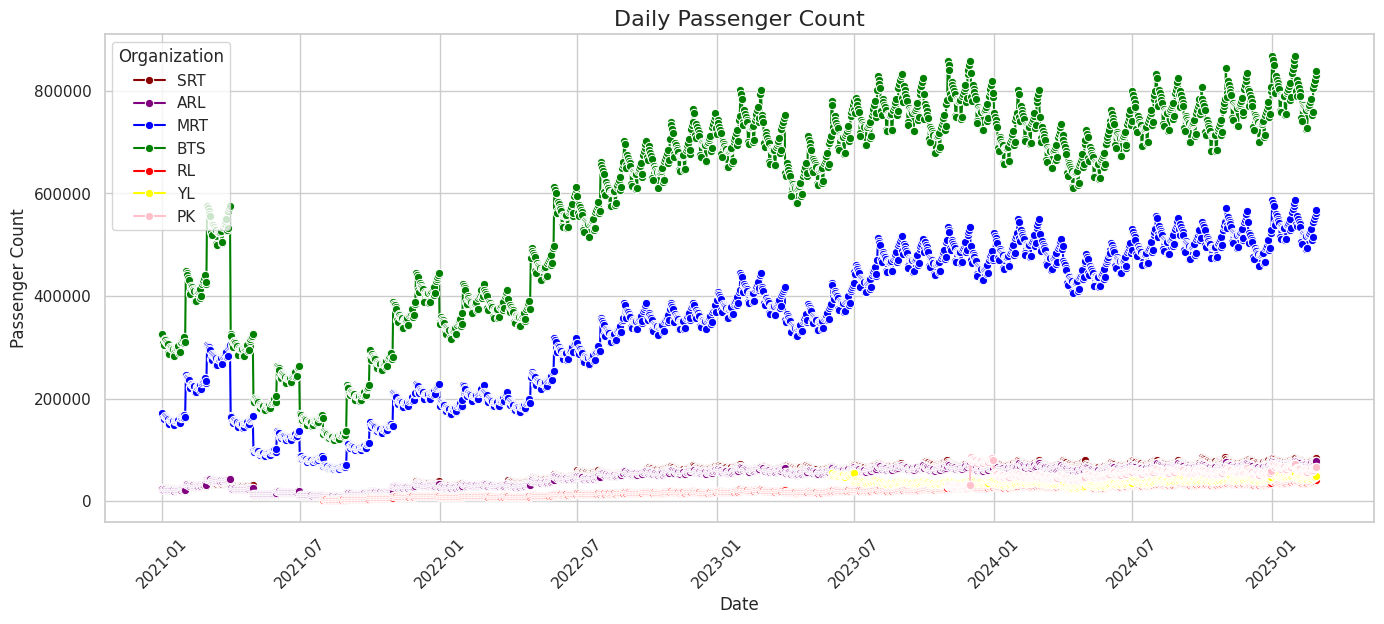

In [ ]:
org_colors = {
    'SRT': 'darkred',
    'ARL': 'purple',
    'MRT': 'blue',
    'BTS': 'green',
    'RL': 'red',
    'YL': 'yellow',
    'PK': 'pink'
}
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
sns.lineplot(data=daily_df, x='Date', y='Passenger_Count', hue='Organization', palette=org_colors, marker="o")
plt.title('Daily Passenger Count', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend(title='Organization')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Find operating time for each train line

*   BTS : 06:00 - 00:00 Total 18 hours
*   YL : 06:00 - 00:00 Total 18 hours
*   PK : 06:00 - 00:00 Total 18 hours
*   MRT : 05:30 - 00:00 Total 18.5 hours
*   ARL : 05:30 - 00:00 Total 18.5 hours
*   SRT : 05:30 - 00:00 Total 18.5 hours
*   RL : 05:30 - 00:00 Total 18.5 hours



## Divide into 30 minutes interval

In [ ]:
org_hours = {
    'BTS': ('06:00', '00:00'),
    'YL': ('06:00', '00:00'),
    'PK': ('06:00', '00:00'),
    'MRT': ('05:30', '00:00'),
    'ARL': ('05:30', '00:00'),
    'SRT': ('05:30', '00:00'),
    'RL': ('05:30', '00:00')
}
def get_time_block(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

hourly_rows = []

for _, row in daily_df.iterrows():
    org = row['Organization']
    date = row['Date']
    total_passengers = row['Passenger_Count']
    start_str, end_str = org_hours.get(org, ('06:00', '00:00'))
    start_dt = pd.to_datetime(f"{date.date()} {start_str}")
    if end_str == '00:00':
        end_dt = pd.to_datetime(f"{date.date()} 23:59")
    else:
        end_dt = pd.to_datetime(f"{date.date()} {end_str}")
    hours = pd.date_range(start=start_dt, end=end_dt, freq='30T')

    weight = []
    for dt in hours:
        h = dt.hour + dt.minute / 60
        if 5.5 <= h <= 9:  # Morning rush hour
            val = 1 + 0.3 * np.sin((h - 6) / 3 * np.pi)
        elif 15 <= h <= 21:  # Evening rush hour
            val = 1 + 0.4 * np.sin((h - 15) / 6 * np.pi)
        else:  # Non-rush hour
            val = 1.0
        weight.append(val)

    weight = np.array(weight)
    weight = weight / weight.sum()
    hourly_passengers = (weight * total_passengers).round().astype(int)
    diff = total_passengers - hourly_passengers.sum()
    if diff != 0:
        hourly_passengers[-1] += diff
    for hour, passengers in zip(hours, hourly_passengers):
        day_of_week = hour.strftime('%A')
        hourly_rows.append({
            'Datetime': hour,
            'Date': date,
            'Hour': hour.hour,
            'Organization': org,
            'Passenger_Count': passengers,
            'Time_Block': get_time_block(hour.hour),
            'Day_of_Week': day_of_week
        })
hourly_df = pd.DataFrame(hourly_rows)
daily_passengers = daily_df.groupby('Date')['Passenger_Count'].sum()
hourly_passengers_check = hourly_df.groupby('Date')['Passenger_Count'].sum()
daily_passengers.equals(hourly_passengers_check)


<ipython-input-124-b73847435d68>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hours = pd.date_range(start=start_dt, end=end_dt, freq='30T')


True

In [ ]:
hourly_df.head(40)

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week
0,2021-01-01 05:30:00,2021-01-01,5,SRT,546,Morning,Friday
1,2021-01-01 06:00:00,2021-01-01,6,SRT,643,Morning,Friday
2,2021-01-01 06:30:00,2021-01-01,6,SRT,739,Morning,Friday
3,2021-01-01 07:00:00,2021-01-01,7,SRT,810,Morning,Friday
4,2021-01-01 07:30:00,2021-01-01,7,SRT,836,Morning,Friday
5,2021-01-01 08:00:00,2021-01-01,8,SRT,810,Morning,Friday
6,2021-01-01 08:30:00,2021-01-01,8,SRT,739,Morning,Friday
7,2021-01-01 09:00:00,2021-01-01,9,SRT,643,Morning,Friday
8,2021-01-01 09:30:00,2021-01-01,9,SRT,643,Morning,Friday
9,2021-01-01 10:00:00,2021-01-01,10,SRT,643,Morning,Friday


## Add up 2 x 30 minutes into 1 hour then Sort the data by organization

In [ ]:
order = ['SRT', 'ARL', 'RL', 'MRT', 'YL', 'PK', 'BTS']
merged_df = hourly_df.groupby(['Date', 'Organization', 'Time_Block', 'Hour'], as_index=False).agg({
    'Passenger_Count': 'sum',
    'Datetime': 'first'
})
merged_df['Organization'] = pd.Categorical(merged_df['Organization'], categories=order, ordered=True)
merged_df = merged_df.sort_values(by=['Date', 'Organization', 'Datetime']).reset_index(drop=True)
merged_df.head(40)

,Date,Organization,Time_Block,Hour,Passenger_Count,Datetime
0,2021-01-01,SRT,Morning,5,546,2021-01-01 05:30:00
1,2021-01-01,SRT,Morning,6,1382,2021-01-01 06:00:00
2,2021-01-01,SRT,Morning,7,1646,2021-01-01 07:00:00
3,2021-01-01,SRT,Morning,8,1549,2021-01-01 08:00:00
4,2021-01-01,SRT,Morning,9,1286,2021-01-01 09:00:00
5,2021-01-01,SRT,Morning,10,1286,2021-01-01 10:00:00
6,2021-01-01,SRT,Morning,11,1286,2021-01-01 11:00:00
7,2021-01-01,SRT,Afternoon,12,1286,2021-01-01 12:00:00
8,2021-01-01,SRT,Afternoon,13,1286,2021-01-01 13:00:00
9,2021-01-01,SRT,Afternoon,14,1286,2021-01-01 14:00:00


## View the distribution of the passenger per hour dataframe

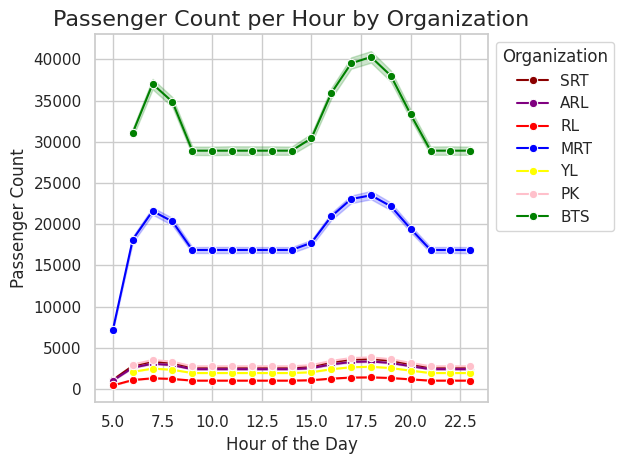

In [ ]:
org_colors = {
    'SRT': 'darkred',
    'ARL': 'purple',
    'MRT': 'blue',
    'BTS': 'green',
    'RL': 'red',
    'YL': 'yellow',
    'PK': 'pink'
}
sns.lineplot(data=merged_df, x='Hour', y='Passenger_Count', hue='Organization', palette=org_colors, marker='o', estimator='mean')
plt.title('Passenger Count per Hour by Organization', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.legend(title='Organization', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Create new dataset for integrated data with weather data

In [ ]:
integrated_df = pd.read_csv("integrated_weather_and_train.csv")
integrated_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb
0,1/1/2021 5:00,1/1/2021,5,SRT,546,Morning,Friday,20.9,43,1015.0
1,1/1/2021 6:00,1/1/2021,6,SRT,643,Morning,Friday,20.4,44,1015.0
2,1/1/2021 7:00,1/1/2021,7,SRT,810,Morning,Friday,20.3,44,1016.0
3,1/1/2021 8:00,1/1/2021,8,SRT,810,Morning,Friday,21.1,43,1016.0
4,1/1/2021 9:00,1/1/2021,9,SRT,643,Morning,Friday,22.0,43,1017.0


## Create a function for rating number of passengers (Is it high or low?)

In [ ]:
def rate_passenger_count(x, bins):
    return pd.cut(x, bins=bins, labels=["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"], include_lowest=True)

In [ ]:
rated_df = integrated_df.copy()
rated_df["Passenger_Rating"] = rated_df.groupby("Organization")["Passenger_Count"].transform(lambda x: rate_passenger_count(x, bins=pd.qcut(x, q=6, retbins=True)[1]))
rating_map = {"Very Low": 0, "Low": 1, "Moderate": 2, "Crowded": 3, "Dense": 4, "Very Dense": 5}
rated_df.head(10)

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
0,1/1/2021 5:00,1/1/2021,5,SRT,546,Morning,Friday,20.9,43,1015.0,Very Low
1,1/1/2021 6:00,1/1/2021,6,SRT,643,Morning,Friday,20.4,44,1015.0,Very Low
2,1/1/2021 7:00,1/1/2021,7,SRT,810,Morning,Friday,20.3,44,1016.0,Low
3,1/1/2021 8:00,1/1/2021,8,SRT,810,Morning,Friday,21.1,43,1016.0,Low
4,1/1/2021 9:00,1/1/2021,9,SRT,643,Morning,Friday,22.0,43,1017.0,Very Low
5,1/1/2021 10:00,1/1/2021,10,SRT,643,Morning,Friday,23.2,41,1016.0,Very Low
6,1/1/2021 11:00,1/1/2021,11,SRT,643,Morning,Friday,24.4,39,1015.0,Very Low
7,1/1/2021 12:00,1/1/2021,12,SRT,643,Afternoon,Friday,26.6,37,1015.0,Very Low
8,1/1/2021 13:00,1/1/2021,13,SRT,643,Afternoon,Friday,27.4,35,1014.0,Very Low
9,1/1/2021 14:00,1/1/2021,14,SRT,643,Afternoon,Friday,28.3,33,1013.0,Very Low


## State Railway of Thailand with rating of passenger count

In [ ]:
srt_df = rated_df[rated_df["Organization"] == "SRT"]
srt_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
0,1/1/2021 5:00,1/1/2021,5,SRT,546,Morning,Friday,20.9,43,1015.0,Very Low
1,1/1/2021 6:00,1/1/2021,6,SRT,643,Morning,Friday,20.4,44,1015.0,Very Low
2,1/1/2021 7:00,1/1/2021,7,SRT,810,Morning,Friday,20.3,44,1016.0,Low
3,1/1/2021 8:00,1/1/2021,8,SRT,810,Morning,Friday,21.1,43,1016.0,Low
4,1/1/2021 9:00,1/1/2021,9,SRT,643,Morning,Friday,22.0,43,1017.0,Very Low


In [ ]:
srt_df = rated_df[rated_df["Organization"] == "SRT"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
srt_df = srt_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.02, 0.17, 0.5, 0.83, 0.98, 1.0]
quantiles = srt_df["Passenger_Count"].quantile(quantile_edges).values
srt_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(srt_bins)-1]

srt_df["Passenger_Rating"] = pd.cut(
    srt_df["Passenger_Count"],
    bins=srt_bins,
    labels=labels,
    include_lowest=True
)
srt_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    srt_df[col] = le.fit_transform(srt_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
srt_df["Rating_Label"] = target_le.fit_transform(srt_df["Passenger_Rating"])

max_count = srt_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in srt_df["Rating_Label"].unique():
    group = srt_df[srt_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.43      0.42      0.43       952
       Dense       0.35      0.27      0.31       953
         Low       0.28      0.15      0.19       953
    Moderate       0.30      0.16      0.21       953
  Very Dense       0.51      0.78      0.62       953
    Very Low       0.46      0.77      0.58       953

    accuracy                           0.42      5717
   macro avg       0.39      0.42      0.39      5717
weighted avg       0.39      0.42      0.39      5717



<ipython-input-133-336ac4ef4792>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=srt_df, x='Passenger_Rating', y='Passenger_Count', estimator='mean', palette='Set2')


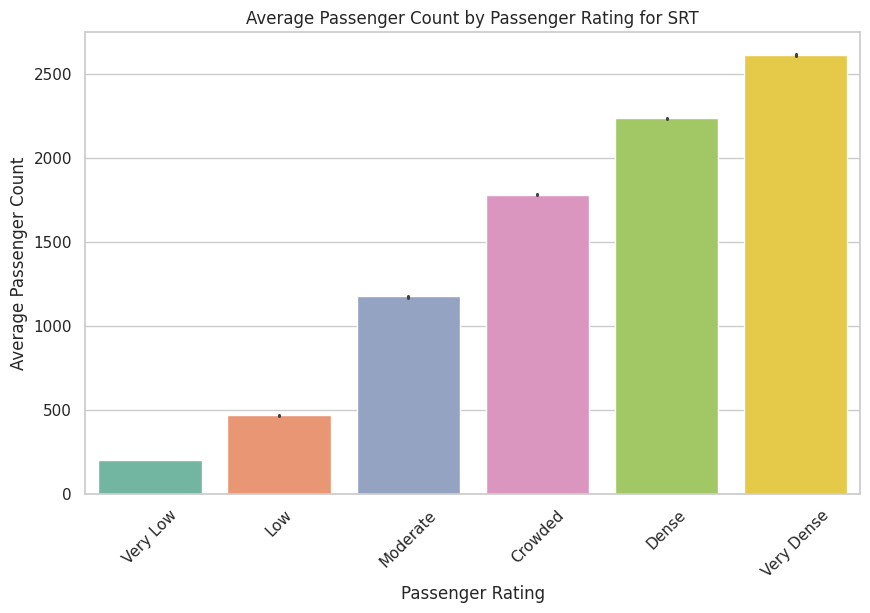

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=srt_df, x='Passenger_Rating', y='Passenger_Count', estimator='mean', palette='Set2')
plt.title('Average Passenger Count by Passenger Rating for SRT')
plt.xlabel('Passenger Rating')
plt.ylabel('Average Passenger Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
srt_df_c = srt_df.copy()
srt_df_c = srt_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
srt_df_c['Time_Block'] = label_encoder.fit_transform(srt_df_c['Time_Block'])
srt_df_c['Day_of_Week'] = label_encoder.fit_transform(srt_df_c['Day_of_Week'])
srt_df_c['Passenger_Rating'] = srt_df_c['Passenger_Rating'].map(rating_map)

X = srt_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
y = srt_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.48
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.6650
Model:                       QuantReg   Bandwidth:                       38.62
Method:                 Least Squares   Sparsity:                        563.6
Date:                Tue, 08 Apr 2025   No. Observations:                23104
Time:                        10:35:32   Df Residuals:                    23096
                                        Df Model:                            7
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1439.7840      1.854    776.750      0.000    1436.151    1443.417
x1            -6.6958      1.961     -3.414      0.001     -10.540      -2.852
x2             4.0926      2.279      1.796      0.073      -0.374       8.559
x3            -1.2032      1.854     -0.649      0.5

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 210856.40
Quantile: 0.02, MSE: 199017.85
Quantile: 0.03, MSE: 181229.64
Quantile: 0.04, MSE: 166970.00
Quantile: 0.05, MSE: 158785.87
Quantile: 0.06, MSE: 150871.97
Quantile: 0.07, MSE: 143265.36
Quantile: 0.08, MSE: 138225.47


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.09, MSE: 132983.97
Quantile: 0.10, MSE: 128204.87
Quantile: 0.11, MSE: 123975.60
Quantile: 0.12, MSE: 119411.74
Quantile: 0.13, MSE: 114951.21
Quantile: 0.14, MSE: 111123.95
Quantile: 0.15, MSE: 107625.21
Quantile: 0.16, MSE: 103944.78
Quantile: 0.17, MSE: 100368.69
Quantile: 0.18, MSE: 96066.49
Quantile: 0.19, MSE: 92625.91
Quantile: 0.20, MSE: 88897.55
Quantile: 0.21, MSE: 85730.78
Quantile: 0.22, MSE: 82094.67
Quantile: 0.23, MSE: 78946.73
Quantile: 0.24, MSE: 75509.94
Quantile: 0.25, MSE: 72384.13
Quantile: 0.26, MSE: 69587.72
Quantile: 0.27, MSE: 67300.61
Quantile: 0.28, MSE: 65128.08
Quantile: 0.29, MSE: 63207.22
Quantile: 0.30, MSE: 61733.80
Quantile: 0.31, MSE: 60332.57
Quantile: 0.32, MSE: 59099.99
Quantile: 0.33, MSE: 57959.41
Quantile: 0.34, MSE: 56864.78
Quantile: 0.35, MSE: 55746.11
Quantile: 0.36, MSE: 54515.35
Quantile: 0.37, MSE: 53101.11
Quantile: 0.38, MSE: 51641.85
Quantile: 0.39, MSE: 50208.99
Quantile: 0.40, MSE: 49075.20
Quantile: 0.41, MSE: 48240.43
Q

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.91, MSE: 150382.44
Quantile: 0.92, MSE: 154508.20
Quantile: 0.93, MSE: 158929.03
Quantile: 0.94, MSE: 164670.47
Quantile: 0.95, MSE: 169657.66


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.96, MSE: 174807.97
Quantile: 0.97, MSE: 180175.65
Quantile: 0.98, MSE: 185975.77
Quantile: 0.99, MSE: 192600.53
Best quantile: 0.48 with MSE: 45239.88


## Red line with rating of passenger count

In [ ]:
rl_df = rated_df[rated_df["Organization"] == "RL"]
rl_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
17078,1/8/2021 5:00,1/8/2021,5,RL,62,Morning,Sunday,27.0,69,1007.0,Very Low
17079,1/8/2021 6:00,1/8/2021,6,RL,73,Morning,Sunday,27.0,69,1007.0,Very Low
17080,1/8/2021 7:00,1/8/2021,7,RL,92,Morning,Sunday,27.8,66,1007.0,Very Low
17081,1/8/2021 8:00,1/8/2021,8,RL,92,Morning,Sunday,28.7,63,1007.0,Very Low
17082,1/8/2021 9:00,1/8/2021,9,RL,73,Morning,Sunday,29.5,60,1007.0,Very Low


In [ ]:
rl_df = rated_df[rated_df["Organization"] == "RL"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
rl_df = rl_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.02, 0.07, 0.5, 0.93, 0.98, 1.0]
quantiles = rl_df["Passenger_Count"].quantile(quantile_edges).values
rl_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(rl_bins)-1]

rl_df["Passenger_Rating"] = pd.cut(
    rl_df["Passenger_Count"],
    bins=rl_bins,
    labels=labels,
    include_lowest=True
)
rl_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    rl_df[col] = le.fit_transform(rl_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
rl_df["Rating_Label"] = target_le.fit_transform(rl_df["Passenger_Rating"])

max_count = rl_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in rl_df["Rating_Label"].unique():
    group = rl_df[rl_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.48      0.29      0.36      1070
       Dense       0.34      0.30      0.32      1070
         Low       0.36      0.59      0.45      1070
    Moderate       0.35      0.16      0.22      1070
  Very Dense       0.51      0.64      0.57      1070
    Very Low       0.50      0.59      0.54      1070

    accuracy                           0.43      6420
   macro avg       0.42      0.43      0.41      6420
weighted avg       0.42      0.43      0.41      6420



In [ ]:
rl_df_c = rl_df.copy()
rl_df_c = rl_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
rl_df_c['Time_Block'] = label_encoder.fit_transform(rl_df_c['Time_Block'])
rl_df_c['Day_of_Week'] = label_encoder.fit_transform(rl_df_c['Day_of_Week'])
rl_df_c['Passenger_Rating'] = rl_df_c['Passenger_Rating'].map(rating_map)

X = rl_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
y = rl_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.49
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.5750
Model:                       QuantReg   Bandwidth:                       23.54
Method:                 Least Squares   Sparsity:                        272.9
Date:                Tue, 08 Apr 2025   No. Observations:                19881
Time:                        10:36:21   Df Residuals:                    19873
                                        Df Model:                            7
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        568.1069      0.966    588.161      0.000     566.214     570.000
x1             1.0510      1.018      1.033      0.302      -0.944       3.046
x2            -0.9638      1.181     -0.816      0.414      -3.279       1.351
x3             1.2544      0.966      1.298      0.1

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 53967.32
Quantile: 0.02, MSE: 52368.67
Quantile: 0.03, MSE: 50501.84
Quantile: 0.04, MSE: 48851.51
Quantile: 0.05, MSE: 47912.77
Quantile: 0.06, MSE: 46919.97
Quantile: 0.07, MSE: 45857.91
Quantile: 0.08, MSE: 44190.31
Quantile: 0.09, MSE: 42833.06
Quantile: 0.10, MSE: 41298.53
Quantile: 0.11, MSE: 39873.66
Quantile: 0.12, MSE: 38517.95
Quantile: 0.13, MSE: 37228.33
Quantile: 0.14, MSE: 36254.20


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.15, MSE: 35273.55
Quantile: 0.16, MSE: 34026.91
Quantile: 0.17, MSE: 32706.32
Quantile: 0.18, MSE: 31256.34
Quantile: 0.19, MSE: 29921.16
Quantile: 0.20, MSE: 28331.47
Quantile: 0.21, MSE: 27064.83
Quantile: 0.22, MSE: 25793.32
Quantile: 0.23, MSE: 24610.94
Quantile: 0.24, MSE: 23453.78
Quantile: 0.25, MSE: 22594.33
Quantile: 0.26, MSE: 21722.80
Quantile: 0.27, MSE: 20899.07
Quantile: 0.28, MSE: 20266.52
Quantile: 0.29, MSE: 19580.39
Quantile: 0.30, MSE: 19016.73
Quantile: 0.31, MSE: 18452.74
Quantile: 0.32, MSE: 17895.63
Quantile: 0.33, MSE: 17399.94
Quantile: 0.34, MSE: 16915.95
Quantile: 0.35, MSE: 16499.50
Quantile: 0.36, MSE: 16112.68
Quantile: 0.37, MSE: 15768.95
Quantile: 0.38, MSE: 15488.41
Quantile: 0.39, MSE: 15225.77
Quantile: 0.40, MSE: 15029.17
Quantile: 0.41, MSE: 14855.54
Quantile: 0.42, MSE: 14722.16
Quantile: 0.43, MSE: 14578.85


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.44, MSE: 14448.63
Quantile: 0.45, MSE: 14360.59
Quantile: 0.46, MSE: 14294.75
Quantile: 0.47, MSE: 14246.30
Quantile: 0.48, MSE: 14233.84
Quantile: 0.49, MSE: 14229.50
Quantile: 0.50, MSE: 14245.64
Quantile: 0.51, MSE: 14280.19
Quantile: 0.52, MSE: 14327.66
Quantile: 0.53, MSE: 14387.95
Quantile: 0.54, MSE: 14470.84
Quantile: 0.55, MSE: 14564.06
Quantile: 0.56, MSE: 14669.17
Quantile: 0.57, MSE: 14788.08
Quantile: 0.58, MSE: 14918.36
Quantile: 0.59, MSE: 15070.18
Quantile: 0.60, MSE: 15265.64
Quantile: 0.61, MSE: 15473.68
Quantile: 0.62, MSE: 15797.43
Quantile: 0.63, MSE: 16099.68
Quantile: 0.64, MSE: 16453.52
Quantile: 0.65, MSE: 16815.21


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.66, MSE: 17286.47
Quantile: 0.67, MSE: 17665.24
Quantile: 0.68, MSE: 18096.27
Quantile: 0.69, MSE: 18518.94
Quantile: 0.70, MSE: 18974.36
Quantile: 0.71, MSE: 19462.25
Quantile: 0.72, MSE: 20048.24
Quantile: 0.73, MSE: 20703.23
Quantile: 0.74, MSE: 21371.12


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.75, MSE: 22130.26
Quantile: 0.76, MSE: 22720.25
Quantile: 0.77, MSE: 23193.26
Quantile: 0.78, MSE: 23823.08
Quantile: 0.79, MSE: 24469.66
Quantile: 0.80, MSE: 25128.03
Quantile: 0.81, MSE: 25961.97
Quantile: 0.82, MSE: 26762.77
Quantile: 0.83, MSE: 27426.13
Quantile: 0.84, MSE: 28277.67
Quantile: 0.85, MSE: 29210.31
Quantile: 0.86, MSE: 30203.06
Quantile: 0.87, MSE: 31647.85
Quantile: 0.88, MSE: 33909.18
Quantile: 0.89, MSE: 40544.47
Quantile: 0.90, MSE: 45128.41
Quantile: 0.91, MSE: 47355.03
Quantile: 0.92, MSE: 49727.34
Quantile: 0.93, MSE: 51608.95
Quantile: 0.94, MSE: 54454.41
Quantile: 0.95, MSE: 57438.50
Quantile: 0.96, MSE: 61557.57
Quantile: 0.97, MSE: 66648.18
Quantile: 0.98, MSE: 72968.42
Quantile: 0.99, MSE: 80709.22
Best quantile: 0.49 with MSE: 14229.50


## Airport Rail Link with rating of passenger count

In [ ]:
arl_df = rated_df[rated_df["Organization"] == "ARL"]
arl_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
589,1/1/2021 5:00,1/1/2021,5,ARL,486,Morning,Friday,20.9,43,1015.0,Very Low
590,1/1/2021 6:00,1/1/2021,6,ARL,572,Morning,Friday,20.4,44,1015.0,Very Low
591,1/1/2021 7:00,1/1/2021,7,ARL,721,Morning,Friday,20.3,44,1016.0,Low
592,1/1/2021 8:00,1/1/2021,8,ARL,721,Morning,Friday,21.1,43,1016.0,Low
593,1/1/2021 9:00,1/1/2021,9,ARL,572,Morning,Friday,22.0,43,1017.0,Very Low


In [ ]:
arl_df = rated_df[rated_df["Organization"] == "ARL"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
arl_df = arl_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.02, 0.17, 0.5, 0.83, 0.98, 1.0]
quantiles = arl_df["Passenger_Count"].quantile(quantile_edges).values
arl_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(arl_bins)-1]

arl_df["Passenger_Rating"] = pd.cut(
    arl_df["Passenger_Count"],
    bins=arl_bins,
    labels=labels,
    include_lowest=True
)
arl_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    arl_df[col] = le.fit_transform(arl_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
arl_df["Rating_Label"] = target_le.fit_transform(arl_df["Passenger_Rating"])

max_count = arl_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in arl_df["Rating_Label"].unique():
    group = arl_df[arl_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.40      0.39      0.39       954
       Dense       0.35      0.26      0.30       954
         Low       0.24      0.13      0.17       954
    Moderate       0.27      0.14      0.19       954
  Very Dense       0.52      0.75      0.62       954
    Very Low       0.45      0.78      0.57       954

    accuracy                           0.41      5724
   macro avg       0.37      0.41      0.37      5724
weighted avg       0.37      0.41      0.37      5724



In [ ]:
arl_df_c = arl_df.copy()
arl_df_c = arl_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
arl_df_c['Time_Block'] = label_encoder.fit_transform(arl_df_c['Time_Block'])
arl_df_c['Day_of_Week'] = label_encoder.fit_transform(arl_df_c['Day_of_Week'])
arl_df_c['Passenger_Rating'] = arl_df_c['Passenger_Rating'].map(rating_map)

X = arl_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
print(X)
y = arl_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.51
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

        Hour  Time_Block  Day_of_Week  temperature_c  humidity  pressure_mb  \
589        5           2            0           20.9        43       1015.0   
590        6           2            0           20.4        44       1015.0   
591        7           2            0           20.3        44       1016.0   
592        8           2            0           21.1        43       1016.0   
593        9           2            0           22.0        43       1017.0   
...      ...         ...          ...            ...       ...          ...   
156521    19           1            0           29.5        63       1010.0   
156522    20           1            0           29.2        66       1011.0   
156523    21           3            0           28.8        69       1011.0   
156524    22           3            0           28.6        71       1012.0   
156525    23           3            0           28.2        76       1011.0   

       Passenger_Rating  
589                   1  

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 163678.65
Quantile: 0.02, MSE: 152022.42
Quantile: 0.03, MSE: 141787.87
Quantile: 0.04, MSE: 132543.41
Quantile: 0.05, MSE: 124791.44
Quantile: 0.06, MSE: 117118.51
Quantile: 0.07, MSE: 110657.54
Quantile: 0.08, MSE: 105864.50
Quantile: 0.09, MSE: 101396.10
Quantile: 0.10, MSE: 96914.33
Quantile: 0.11, MSE: 92181.64
Quantile: 0.12, MSE: 87920.26
Quantile: 0.13, MSE: 84359.34
Quantile: 0.14, MSE: 80975.25
Quantile: 0.15, MSE: 77742.16
Quantile: 0.16, MSE: 74911.28
Quantile: 0.17, MSE: 71775.53
Quantile: 0.18, MSE: 68842.17
Quantile: 0.19, MSE: 66293.36
Quantile: 0.20, MSE: 63710.25
Quantile: 0.21, MSE: 61225.91
Quantile: 0.22, MSE: 58514.71
Quantile: 0.23, MSE: 55741.98
Quantile: 0.24, MSE: 53354.42


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.25, MSE: 51418.43


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.26, MSE: 49840.83
Quantile: 0.27, MSE: 48306.39
Quantile: 0.28, MSE: 47230.08
Quantile: 0.29, MSE: 46193.66
Quantile: 0.30, MSE: 45271.94
Quantile: 0.31, MSE: 44416.46
Quantile: 0.32, MSE: 43557.28
Quantile: 0.33, MSE: 42713.01
Quantile: 0.34, MSE: 41871.30
Quantile: 0.35, MSE: 40901.58
Quantile: 0.36, MSE: 40065.73
Quantile: 0.37, MSE: 39138.59
Quantile: 0.38, MSE: 38241.61
Quantile: 0.39, MSE: 37256.22
Quantile: 0.40, MSE: 36518.29
Quantile: 0.41, MSE: 35699.03
Quantile: 0.42, MSE: 35105.01
Quantile: 0.43, MSE: 34550.15
Quantile: 0.44, MSE: 34139.58
Quantile: 0.45, MSE: 33823.68
Quantile: 0.46, MSE: 33554.31
Quantile: 0.47, MSE: 33359.71
Quantile: 0.48, MSE: 33199.56
Quantile: 0.49, MSE: 33092.73
Quantile: 0.50, MSE: 33040.18


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.51, MSE: 33028.29


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.52, MSE: 33062.25
Quantile: 0.53, MSE: 33133.09
Quantile: 0.54, MSE: 33255.12
Quantile: 0.55, MSE: 33438.83
Quantile: 0.56, MSE: 33675.69
Quantile: 0.57, MSE: 33959.81
Quantile: 0.58, MSE: 34316.94
Quantile: 0.59, MSE: 34720.03
Quantile: 0.60, MSE: 35158.49
Quantile: 0.61, MSE: 35645.85
Quantile: 0.62, MSE: 36162.86
Quantile: 0.63, MSE: 36869.90


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.64, MSE: 37623.19
Quantile: 0.65, MSE: 38308.31
Quantile: 0.66, MSE: 39176.34
Quantile: 0.67, MSE: 40048.96
Quantile: 0.68, MSE: 41117.79
Quantile: 0.69, MSE: 42283.30
Quantile: 0.70, MSE: 43385.49
Quantile: 0.71, MSE: 44520.56


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.72, MSE: 45693.74
Quantile: 0.73, MSE: 47131.45
Quantile: 0.74, MSE: 48665.52


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.75, MSE: 50622.39
Quantile: 0.76, MSE: 52929.41
Quantile: 0.77, MSE: 55529.23
Quantile: 0.78, MSE: 58040.56
Quantile: 0.79, MSE: 60305.04
Quantile: 0.80, MSE: 64265.35
Quantile: 0.81, MSE: 67935.04
Quantile: 0.82, MSE: 72872.45
Quantile: 0.83, MSE: 77350.78
Quantile: 0.84, MSE: 80635.32
Quantile: 0.85, MSE: 83983.82
Quantile: 0.86, MSE: 88399.24
Quantile: 0.87, MSE: 93377.82


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.88, MSE: 97036.10
Quantile: 0.89, MSE: 100637.73
Quantile: 0.90, MSE: 103850.61
Quantile: 0.91, MSE: 107432.72
Quantile: 0.92, MSE: 112499.51
Quantile: 0.93, MSE: 116196.27
Quantile: 0.94, MSE: 120267.90
Quantile: 0.95, MSE: 124613.34
Quantile: 0.96, MSE: 128837.66
Quantile: 0.97, MSE: 134825.19
Quantile: 0.98, MSE: 140301.42
Quantile: 0.99, MSE: 146783.83
Best quantile: 0.51 with MSE: 33028.29


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


## BTS with rating of passenger count

In [ ]:
bts_df = rated_df[rated_df["Organization"] == "BTS"]
bts_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
1767,1/1/2021 6:00,1/1/2021,6,BTS,8117,Morning,Friday,20.4,44,1015.0,Very Low
1768,1/1/2021 7:00,1/1/2021,7,BTS,10226,Morning,Friday,20.3,44,1016.0,Low
1769,1/1/2021 8:00,1/1/2021,8,BTS,10226,Morning,Friday,21.1,43,1016.0,Low
1770,1/1/2021 9:00,1/1/2021,9,BTS,8117,Morning,Friday,22.0,43,1017.0,Very Low
1771,1/1/2021 10:00,1/1/2021,10,BTS,8117,Morning,Friday,23.2,41,1016.0,Very Low


In [ ]:
bts_df = rated_df[rated_df["Organization"] == "BTS"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
bts_df = bts_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.02, 0.2, 0.5, 0.8, 0.98, 1.0]
quantiles = bts_df["Passenger_Count"].quantile(quantile_edges).values
bts_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(bts_bins)-1]

bts_df["Passenger_Rating"] = pd.cut(
    bts_df["Passenger_Count"],
    bins=bts_bins,
    labels=labels,
    include_lowest=True
)
bts_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    bts_df[col] = le.fit_transform(bts_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
bts_df["Rating_Label"] = target_le.fit_transform(bts_df["Passenger_Rating"])

max_count = bts_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in bts_df["Rating_Label"].unique():
    group = bts_df[bts_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.35      0.39      0.37       821
       Dense       0.39      0.34      0.36       821
         Low       0.29      0.06      0.11       821
    Moderate       0.32      0.18      0.23       821
  Very Dense       0.52      0.78      0.62       821
    Very Low       0.47      0.80      0.59       821

    accuracy                           0.43      4926
   macro avg       0.39      0.43      0.38      4926
weighted avg       0.39      0.43      0.38      4926



In [ ]:
bts_df_c = bts_df.copy()
bts_df_c = bts_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
bts_df_c['Time_Block'] = label_encoder.fit_transform(bts_df_c['Time_Block'])
bts_df_c['Day_of_Week'] = label_encoder.fit_transform(bts_df_c['Day_of_Week'])
rating_map = {"Very Low": 0, "Low": 1, "Moderate": 2, "Crowded": 3, "Dense": 4, "Very Dense": 5}
bts_df_c['Passenger_Rating'] = bts_df_c['Passenger_Rating'].map(rating_map)

X = bts_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
y = bts_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.49
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.6910
Model:                       QuantReg   Bandwidth:                       315.4
Method:                 Least Squares   Sparsity:                        4227.
Date:                Tue, 08 Apr 2025   No. Observations:                21888
Time:                        10:38:20   Df Residuals:                    21880
                                        Df Model:                            7
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.611e+04     14.287   1127.629      0.000    1.61e+04    1.61e+04
x1           -25.2321     15.109     -1.670      0.095     -54.847       4.383
x2            80.7105     17.615      4.582      0.000      46.185     115.236
x3            17.4072     14.289      1.218      0.2

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 16427628.37
Quantile: 0.02, MSE: 15560325.91
Quantile: 0.03, MSE: 14903634.64
Quantile: 0.04, MSE: 14101143.25
Quantile: 0.05, MSE: 13458222.21
Quantile: 0.06, MSE: 12849320.01
Quantile: 0.07, MSE: 12318147.23
Quantile: 0.08, MSE: 11858060.70
Quantile: 0.09, MSE: 11331134.27
Quantile: 0.10, MSE: 10805784.54
Quantile: 0.11, MSE: 10251538.61
Quantile: 0.12, MSE: 9698054.91
Quantile: 0.13, MSE: 9185651.85
Quantile: 0.14, MSE: 8654691.62
Quantile: 0.15, MSE: 8258272.35
Quantile: 0.16, MSE: 7892789.17
Quantile: 0.17, MSE: 7476377.13
Quantile: 0.18, MSE: 7080089.70
Quantile: 0.19, MSE: 6744371.67
Quantile: 0.20, MSE: 6468123.44
Quantile: 0.21, MSE: 6186936.06
Quantile: 0.22, MSE: 5918485.36
Quantile: 0.23, MSE: 5687924.62
Quantile: 0.24, MSE: 5451518.44
Quantile: 0.25, MSE: 5249535.95
Quantile: 0.26, MSE: 5062350.25


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.27, MSE: 4877977.72
Quantile: 0.28, MSE: 4736398.31
Quantile: 0.29, MSE: 4592104.86


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.30, MSE: 4481121.02
Quantile: 0.31, MSE: 4371327.72
Quantile: 0.32, MSE: 4263399.47
Quantile: 0.33, MSE: 4180412.40
Quantile: 0.34, MSE: 4107504.55
Quantile: 0.35, MSE: 4030085.87
Quantile: 0.36, MSE: 3955502.74
Quantile: 0.37, MSE: 3891271.31
Quantile: 0.38, MSE: 3839649.71
Quantile: 0.39, MSE: 3794669.04
Quantile: 0.40, MSE: 3754493.86
Quantile: 0.41, MSE: 3718825.16
Quantile: 0.42, MSE: 3688939.13
Quantile: 0.43, MSE: 3661649.52
Quantile: 0.44, MSE: 3641176.76
Quantile: 0.45, MSE: 3624336.49
Quantile: 0.46, MSE: 3609358.84
Quantile: 0.47, MSE: 3598821.78
Quantile: 0.48, MSE: 3594044.43
Quantile: 0.49, MSE: 3592441.53
Quantile: 0.50, MSE: 3593906.33
Quantile: 0.51, MSE: 3599563.63
Quantile: 0.52, MSE: 3610667.69
Quantile: 0.53, MSE: 3622994.40
Quantile: 0.54, MSE: 3638724.75
Quantile: 0.55, MSE: 3658918.12
Quantile: 0.56, MSE: 3681488.65
Quantile: 0.57, MSE: 3705808.66
Quantile: 0.58, MSE: 3742066.17
Quantile: 0.59, MSE: 3776417.00


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.60, MSE: 3809174.35
Quantile: 0.61, MSE: 3848277.89
Quantile: 0.62, MSE: 3889082.37
Quantile: 0.63, MSE: 3939428.39
Quantile: 0.64, MSE: 3990451.43
Quantile: 0.65, MSE: 4047187.16
Quantile: 0.66, MSE: 4104681.91
Quantile: 0.67, MSE: 4175761.44
Quantile: 0.68, MSE: 4244884.33
Quantile: 0.69, MSE: 4318473.40
Quantile: 0.70, MSE: 4408855.11
Quantile: 0.71, MSE: 4522527.06
Quantile: 0.72, MSE: 4637575.08
Quantile: 0.73, MSE: 4789543.34
Quantile: 0.74, MSE: 4949988.54
Quantile: 0.75, MSE: 5126281.29
Quantile: 0.76, MSE: 5344878.68
Quantile: 0.77, MSE: 5586099.50
Quantile: 0.78, MSE: 5854626.67
Quantile: 0.79, MSE: 6200596.03
Quantile: 0.80, MSE: 6502346.07
Quantile: 0.81, MSE: 6888315.84
Quantile: 0.82, MSE: 7380794.16
Quantile: 0.83, MSE: 7856661.73
Quantile: 0.84, MSE: 8412289.94
Quantile: 0.85, MSE: 8893019.35
Quantile: 0.86, MSE: 9395565.33
Quantile: 0.87, MSE: 9813788.53
Quantile: 0.88, MSE: 10311341.74
Quantile: 0.89, MSE: 10911938.47
Quantile: 0.90, MSE: 11489441.59
Quant

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


## MRT with rating of passenger count

In [ ]:
mrt_df = rated_df[rated_df["Organization"] == "MRT"]
mrt_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
1178,1/1/2021 5:00,1/1/2021,5,MRT,3550,Morning,Friday,20.9,43,1015.0,Very Low
1179,1/1/2021 6:00,1/1/2021,6,MRT,4177,Morning,Friday,20.4,44,1015.0,Very Low
1180,1/1/2021 7:00,1/1/2021,7,MRT,5262,Morning,Friday,20.3,44,1016.0,Low
1181,1/1/2021 8:00,1/1/2021,8,MRT,5262,Morning,Friday,21.1,43,1016.0,Low
1182,1/1/2021 9:00,1/1/2021,9,MRT,4177,Morning,Friday,22.0,43,1017.0,Very Low


In [ ]:
mrt_df = rated_df[rated_df["Organization"] == "MRT"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
mrt_df = mrt_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.02, 0.07, 0.5, 0.93, 0.98, 1.0]
quantiles = mrt_df["Passenger_Count"].quantile(quantile_edges).values
mrt_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(mrt_bins)-1]

mrt_df["Passenger_Rating"] = pd.cut(
    mrt_df["Passenger_Count"],
    bins=mrt_bins,
    labels=labels,
    include_lowest=True
)
mrt_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    mrt_df[col] = le.fit_transform(mrt_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
mrt_df["Rating_Label"] = target_le.fit_transform(mrt_df["Passenger_Rating"])

max_count = mrt_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in mrt_df["Rating_Label"].unique():
    group = mrt_df[mrt_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.41      0.24      0.30      1242
       Dense       0.41      0.35      0.37      1242
         Low       0.42      0.31      0.36      1242
    Moderate       0.34      0.27      0.30      1242
  Very Dense       0.49      0.73      0.59      1242
    Very Low       0.45      0.68      0.54      1242

    accuracy                           0.43      7452
   macro avg       0.42      0.43      0.41      7452
weighted avg       0.42      0.43      0.41      7452



In [ ]:
mrt_df_c = mrt_df.copy()
mrt_df_c = mrt_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
mrt_df_c['Time_Block'] = label_encoder.fit_transform(mrt_df_c['Time_Block'])
mrt_df_c['Day_of_Week'] = label_encoder.fit_transform(mrt_df_c['Day_of_Week'])
mrt_df_c['Passenger_Rating'] = mrt_df_c['Passenger_Rating'].map(rating_map)

X = mrt_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
y = mrt_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.5
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.5795
Model:                       QuantReg   Bandwidth:                       321.1
Method:                 Least Squares   Sparsity:                        3671.
Date:                Tue, 08 Apr 2025   No. Observations:                23104
Time:                        10:39:19   Df Residuals:                    23096
                                        Df Model:                            7
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9485.5853     12.014    789.547      0.000    9462.037    9509.133
x1            20.8654     12.684      1.645      0.100      -3.995      45.726
x2            -8.5282     14.767     -0.578      0.564     -37.473      20.417
x3            26.3850     12.039      2.192      0.0

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 18281882.17
Quantile: 0.02, MSE: 17151278.75
Quantile: 0.03, MSE: 16134330.02
Quantile: 0.04, MSE: 15184415.32
Quantile: 0.05, MSE: 14409035.31
Quantile: 0.06, MSE: 13573010.84
Quantile: 0.07, MSE: 12653040.09
Quantile: 0.08, MSE: 11969044.38
Quantile: 0.09, MSE: 11136412.15
Quantile: 0.10, MSE: 10371919.18
Quantile: 0.11, MSE: 9653628.52
Quantile: 0.12, MSE: 8934247.19


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.13, MSE: 8360239.66
Quantile: 0.14, MSE: 7967459.27
Quantile: 0.15, MSE: 7663622.97
Quantile: 0.16, MSE: 7434535.58
Quantile: 0.17, MSE: 7172981.61
Quantile: 0.18, MSE: 6952538.59
Quantile: 0.19, MSE: 6682982.14
Quantile: 0.20, MSE: 6404116.84
Quantile: 0.21, MSE: 6147122.98
Quantile: 0.22, MSE: 5822138.70
Quantile: 0.23, MSE: 5626069.66
Quantile: 0.24, MSE: 5445475.49
Quantile: 0.25, MSE: 5271131.18
Quantile: 0.26, MSE: 5074718.25
Quantile: 0.27, MSE: 4878995.62
Quantile: 0.28, MSE: 4716714.70
Quantile: 0.29, MSE: 4558042.77
Quantile: 0.30, MSE: 4419356.88
Quantile: 0.31, MSE: 4265561.03
Quantile: 0.32, MSE: 4115506.15
Quantile: 0.33, MSE: 3990935.30
Quantile: 0.34, MSE: 3899054.60
Quantile: 0.35, MSE: 3810726.31
Quantile: 0.36, MSE: 3744172.15
Quantile: 0.37, MSE: 3690209.22


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.38, MSE: 3642804.96
Quantile: 0.39, MSE: 3604237.37
Quantile: 0.40, MSE: 3561487.68
Quantile: 0.41, MSE: 3527143.59
Quantile: 0.42, MSE: 3503414.50
Quantile: 0.43, MSE: 3481123.97
Quantile: 0.44, MSE: 3462341.94
Quantile: 0.45, MSE: 3447871.97
Quantile: 0.46, MSE: 3435387.77
Quantile: 0.47, MSE: 3424315.89
Quantile: 0.48, MSE: 3418487.55
Quantile: 0.49, MSE: 3414043.51
Quantile: 0.50, MSE: 3412467.36
Quantile: 0.51, MSE: 3414481.07
Quantile: 0.52, MSE: 3418683.64
Quantile: 0.53, MSE: 3424437.29
Quantile: 0.54, MSE: 3433685.02
Quantile: 0.55, MSE: 3447035.36
Quantile: 0.56, MSE: 3460380.96
Quantile: 0.57, MSE: 3477187.33
Quantile: 0.58, MSE: 3497928.29
Quantile: 0.59, MSE: 3521839.10


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.60, MSE: 3563754.42
Quantile: 0.61, MSE: 3618099.27
Quantile: 0.62, MSE: 3702078.59
Quantile: 0.63, MSE: 3806066.33
Quantile: 0.64, MSE: 3925123.37
Quantile: 0.65, MSE: 4054786.20
Quantile: 0.66, MSE: 4164478.12
Quantile: 0.67, MSE: 4284762.28
Quantile: 0.68, MSE: 4417472.51
Quantile: 0.69, MSE: 4552346.61
Quantile: 0.70, MSE: 4707479.29
Quantile: 0.71, MSE: 4869784.52
Quantile: 0.72, MSE: 4998670.76
Quantile: 0.73, MSE: 5126781.58


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.74, MSE: 5257631.42
Quantile: 0.75, MSE: 5364738.88
Quantile: 0.76, MSE: 5511433.99
Quantile: 0.77, MSE: 5652561.58
Quantile: 0.78, MSE: 5804003.98
Quantile: 0.79, MSE: 5997749.86
Quantile: 0.80, MSE: 6269235.77
Quantile: 0.81, MSE: 6448698.84
Quantile: 0.82, MSE: 6650004.55
Quantile: 0.83, MSE: 6823075.94
Quantile: 0.84, MSE: 6976537.22
Quantile: 0.85, MSE: 7135019.53
Quantile: 0.86, MSE: 7319841.83
Quantile: 0.87, MSE: 7578363.04
Quantile: 0.88, MSE: 7862582.50
Quantile: 0.89, MSE: 8159284.95
Quantile: 0.90, MSE: 8501806.99
Quantile: 0.91, MSE: 8971857.92


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.92, MSE: 9643093.63
Quantile: 0.93, MSE: 10435201.84
Quantile: 0.94, MSE: 11372228.48
Quantile: 0.95, MSE: 12110685.51
Quantile: 0.96, MSE: 13071020.69
Quantile: 0.97, MSE: 14127438.09
Quantile: 0.98, MSE: 15432439.57
Quantile: 0.99, MSE: 16940466.47
Best quantile: 0.50 with MSE: 3412467.36


## Yellow line with rating of passenger count

In [ ]:
yl_df = rated_df[rated_df["Organization"] == "YL"]
yl_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
81066,1/6/2023 6:00,1/6/2023,6,YL,1369,Morning,Thursday,28.7,64,1006.0,Very Dense
81067,1/6/2023 7:00,1/6/2023,7,YL,1725,Morning,Thursday,29.4,61,1006.0,Very Dense
81068,1/6/2023 8:00,1/6/2023,8,YL,1725,Morning,Thursday,30.8,55,1007.0,Very Dense
81069,1/6/2023 9:00,1/6/2023,9,YL,1369,Morning,Thursday,32.3,49,1007.0,Very Dense
81070,1/6/2023 10:00,1/6/2023,10,YL,1369,Morning,Thursday,33.0,42,1007.0,Very Dense


In [ ]:
yl_df = rated_df[rated_df["Organization"] == "YL"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
yl_df = yl_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.025, 0.22, 0.5, 0.78, 0.975, 1.0]
quantiles = yl_df["Passenger_Count"].quantile(quantile_edges).values
yl_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(yl_bins)-1]

yl_df["Passenger_Rating"] = pd.cut(
    yl_df["Passenger_Count"],
    bins=yl_bins,
    labels=labels,
    include_lowest=True
)
yl_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    yl_df[col] = le.fit_transform(yl_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
yl_df["Rating_Label"] = target_le.fit_transform(yl_df["Passenger_Rating"])

max_count = yl_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in yl_df["Rating_Label"].unique():
    group = yl_df[yl_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.31      0.27      0.29       322
       Dense       0.45      0.27      0.34       322
         Low       0.45      0.29      0.35       322
    Moderate       0.37      0.33      0.35       323
  Very Dense       0.51      0.76      0.61       323
    Very Low       0.54      0.80      0.65       322

    accuracy                           0.45      1934
   macro avg       0.44      0.45      0.43      1934
weighted avg       0.44      0.45      0.43      1934



In [ ]:
yl_df_c = yl_df.copy()
yl_df_c = yl_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
yl_df_c['Time_Block'] = label_encoder.fit_transform(yl_df_c['Time_Block'])
yl_df_c['Day_of_Week'] = label_encoder.fit_transform(yl_df_c['Day_of_Week'])
yl_df_c['Passenger_Rating'] = yl_df_c['Passenger_Rating'].map(rating_map)

X = yl_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
y = yl_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.56
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.6851
Model:                       QuantReg   Bandwidth:                       15.38
Method:                 Least Squares   Sparsity:                        189.5
Date:                Tue, 08 Apr 2025   No. Observations:                 9201
Time:                        10:40:21   Df Residuals:                     9193
                                        Df Model:                            7
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1081.0084      0.981   1102.338      0.000    1079.086    1082.931
x1             5.1629      1.044      4.946      0.000       3.117       7.209
x2            -7.6638      1.228     -6.242      0.000     -10.070      -5.257
x3            -1.6472      0.982     -1.678      0.0

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 16507.35
Quantile: 0.02, MSE: 15746.34
Quantile: 0.03, MSE: 14943.57
Quantile: 0.04, MSE: 14376.70
Quantile: 0.05, MSE: 13852.35
Quantile: 0.06, MSE: 13356.55
Quantile: 0.07, MSE: 12920.91
Quantile: 0.08, MSE: 12514.35
Quantile: 0.09, MSE: 12125.44
Quantile: 0.10, MSE: 11854.45
Quantile: 0.11, MSE: 11500.25
Quantile: 0.12, MSE: 11230.93
Quantile: 0.13, MSE: 10964.15
Quantile: 0.14, MSE: 10741.96
Quantile: 0.15, MSE: 10478.09
Quantile: 0.16, MSE: 10234.96
Quantile: 0.17, MSE: 10005.79
Quantile: 0.18, MSE: 9776.09
Quantile: 0.19, MSE: 9558.78
Quantile: 0.20, MSE: 9304.95
Quantile: 0.21, MSE: 9057.84
Quantile: 0.22, MSE: 8862.13


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.23, MSE: 8653.18
Quantile: 0.24, MSE: 8449.23
Quantile: 0.25, MSE: 8262.73
Quantile: 0.26, MSE: 8078.43
Quantile: 0.27, MSE: 7863.07
Quantile: 0.28, MSE: 7657.62
Quantile: 0.29, MSE: 7501.79
Quantile: 0.30, MSE: 7369.94


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.31, MSE: 7220.86
Quantile: 0.32, MSE: 7083.62
Quantile: 0.33, MSE: 6944.59
Quantile: 0.34, MSE: 6807.99
Quantile: 0.35, MSE: 6688.79
Quantile: 0.36, MSE: 6550.80
Quantile: 0.37, MSE: 6427.85
Quantile: 0.38, MSE: 6308.19
Quantile: 0.39, MSE: 6226.48
Quantile: 0.40, MSE: 6155.76
Quantile: 0.41, MSE: 6074.69
Quantile: 0.42, MSE: 6002.95
Quantile: 0.43, MSE: 5920.83
Quantile: 0.44, MSE: 5848.01
Quantile: 0.45, MSE: 5786.36
Quantile: 0.46, MSE: 5728.85
Quantile: 0.47, MSE: 5669.46
Quantile: 0.48, MSE: 5620.46
Quantile: 0.49, MSE: 5556.89
Quantile: 0.50, MSE: 5504.10
Quantile: 0.51, MSE: 5468.40
Quantile: 0.52, MSE: 5442.59
Quantile: 0.53, MSE: 5408.94
Quantile: 0.54, MSE: 5380.07
Quantile: 0.55, MSE: 5363.65
Quantile: 0.56, MSE: 5360.91


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.57, MSE: 5372.03
Quantile: 0.58, MSE: 5381.65
Quantile: 0.59, MSE: 5416.47
Quantile: 0.60, MSE: 5435.09
Quantile: 0.61, MSE: 5467.71
Quantile: 0.62, MSE: 5513.65
Quantile: 0.63, MSE: 5582.01
Quantile: 0.64, MSE: 5644.72
Quantile: 0.65, MSE: 5719.52
Quantile: 0.66, MSE: 5812.46
Quantile: 0.67, MSE: 5897.87
Quantile: 0.68, MSE: 5979.53
Quantile: 0.69, MSE: 6078.35
Quantile: 0.70, MSE: 6194.00
Quantile: 0.71, MSE: 6297.31
Quantile: 0.72, MSE: 6417.41
Quantile: 0.73, MSE: 6560.06
Quantile: 0.74, MSE: 6717.61
Quantile: 0.75, MSE: 6897.22
Quantile: 0.76, MSE: 7087.84
Quantile: 0.77, MSE: 7304.59
Quantile: 0.78, MSE: 7548.56
Quantile: 0.79, MSE: 7801.81
Quantile: 0.80, MSE: 8031.46
Quantile: 0.81, MSE: 8280.89
Quantile: 0.82, MSE: 8672.53
Quantile: 0.83, MSE: 9049.11
Quantile: 0.84, MSE: 9428.41
Quantile: 0.85, MSE: 9869.94
Quantile: 0.86, MSE: 10502.59
Quantile: 0.87, MSE: 11043.00
Quantile: 0.88, MSE: 11789.85
Quantile: 0.89, MSE: 12664.28
Quantile: 0.90, MSE: 13546.32
Quantile:

## Pink line with rating of passenger count

In [ ]:
pk_df = rated_df[rated_df["Organization"] == "PK"]
pk_df.head()

,Datetime,Date,Hour,Organization,Passenger_Count,Time_Block,Day_of_Week,temperature_c,humidity,pressure_mb,Passenger_Rating
98742,1/11/2023 6:00,1/11/2023,6,PK,798,Morning,Wednesday,24.4,88,1012.0,Very Low
98743,1/11/2023 7:00,1/11/2023,7,PK,1006,Morning,Wednesday,24.6,86,1013.0,Very Low
98744,1/11/2023 8:00,1/11/2023,8,PK,1006,Morning,Wednesday,25.5,80,1014.0,Very Low
98745,1/11/2023 9:00,1/11/2023,9,PK,798,Morning,Wednesday,26.7,74,1014.0,Very Low
98746,1/11/2023 10:00,1/11/2023,10,PK,798,Morning,Wednesday,28.1,69,1015.0,Very Low


In [ ]:
pk_df = rated_df[rated_df["Organization"] == "PK"].copy()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
pk_df = pk_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.025, 0.22, 0.5, 0.78, 0.975, 1.0]
quantiles = pk_df["Passenger_Count"].quantile(quantile_edges).values
pk_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(pk_bins)-1]

pk_df["Passenger_Rating"] = pd.cut(
    pk_df["Passenger_Count"],
    bins=pk_bins,
    labels=labels,
    include_lowest=True
)
pk_bins = np.unique(quantiles)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    pk_df[col] = le.fit_transform(pk_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
pk_df["Rating_Label"] = target_le.fit_transform(pk_df["Passenger_Rating"])
max_count = pk_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in pk_df["Rating_Label"].unique():
    group = pk_df[pk_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.38      0.09      0.15       244
       Dense       0.45      0.38      0.41       245
         Low       0.44      0.44      0.44       245
    Moderate       0.49      0.40      0.44       245
  Very Dense       0.55      0.69      0.61       245
    Very Low       0.45      0.83      0.58       245

    accuracy                           0.47      1469
   macro avg       0.46      0.47      0.44      1469
weighted avg       0.46      0.47      0.44      1469



In [ ]:
pk_df_c = pk_df.copy()
pk_df_c = pk_df_c.drop(columns=['Organization','Datetime'])

label_encoder = LabelEncoder()
pk_df_c['Time_Block'] = label_encoder.fit_transform(pk_df_c['Time_Block'])
pk_df_c['Day_of_Week'] = label_encoder.fit_transform(pk_df_c['Day_of_Week'])
pk_df_c['Passenger_Rating'] = pk_df_c['Passenger_Rating'].map(rating_map)

X = pk_df_c.drop(columns=['Passenger_Count', 'Date','Rating_Label'])
y = pk_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.45
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.6676
Model:                       QuantReg   Bandwidth:                       28.90
Method:                 Least Squares   Sparsity:                        296.6
Date:                Tue, 08 Apr 2025   No. Observations:                 6998
Time:                        10:42:06   Df Residuals:                     6990
                                        Df Model:                            7
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1514.9946      1.764    858.922      0.000    1511.537    1518.452
x1             0.3304      1.893      0.175      0.861      -3.380       4.041
x2             5.1619      2.252      2.293      0.022       0.748       9.576
x3            -1.6740      1.762     -0.950      0.3

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 72054.21
Quantile: 0.02, MSE: 66180.70
Quantile: 0.03, MSE: 56339.97
Quantile: 0.04, MSE: 49037.85
Quantile: 0.05, MSE: 45199.00
Quantile: 0.06, MSE: 41599.87
Quantile: 0.07, MSE: 38497.10
Quantile: 0.08, MSE: 35533.77
Quantile: 0.09, MSE: 33439.20
Quantile: 0.10, MSE: 32186.44
Quantile: 0.11, MSE: 31084.34
Quantile: 0.12, MSE: 30228.61
Quantile: 0.13, MSE: 29348.08
Quantile: 0.14, MSE: 28288.82
Quantile: 0.15, MSE: 27519.21
Quantile: 0.16, MSE: 26665.21
Quantile: 0.17, MSE: 26065.67
Quantile: 0.18, MSE: 25397.69
Quantile: 0.19, MSE: 24695.48
Quantile: 0.20, MSE: 23994.20
Quantile: 0.21, MSE: 23508.10
Quantile: 0.22, MSE: 22834.14
Quantile: 0.23, MSE: 22264.75
Quantile: 0.24, MSE: 21654.08
Quantile: 0.25, MSE: 21008.45
Quantile: 0.26, MSE: 20381.04
Quantile: 0.27, MSE: 19748.33
Quantile: 0.28, MSE: 19290.82
Quantile: 0.29, MSE: 18780.70
Quantile: 0.30, MSE: 18378.11
Quantile: 0.31, MSE: 18004.58
Quantile: 0.32, MSE: 17609.84
Quantile: 0.33, MSE: 17235.00
Quantile: 

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.42, MSE: 15300.53
Quantile: 0.43, MSE: 15218.25
Quantile: 0.44, MSE: 15122.13
Quantile: 0.45, MSE: 15076.25


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.46, MSE: 15151.87
Quantile: 0.47, MSE: 15124.77
Quantile: 0.48, MSE: 15148.31
Quantile: 0.49, MSE: 15184.68
Quantile: 0.50, MSE: 15229.34
Quantile: 0.51, MSE: 15252.43
Quantile: 0.52, MSE: 15319.19
Quantile: 0.53, MSE: 15463.41
Quantile: 0.54, MSE: 15535.64
Quantile: 0.55, MSE: 15612.37
Quantile: 0.56, MSE: 15717.40
Quantile: 0.57, MSE: 15829.05
Quantile: 0.58, MSE: 15980.03
Quantile: 0.59, MSE: 16075.49
Quantile: 0.60, MSE: 16251.88
Quantile: 0.61, MSE: 16396.96
Quantile: 0.62, MSE: 16521.14
Quantile: 0.63, MSE: 16687.11
Quantile: 0.64, MSE: 16920.19
Quantile: 0.65, MSE: 17085.39
Quantile: 0.66, MSE: 17294.74
Quantile: 0.67, MSE: 17530.13
Quantile: 0.68, MSE: 17805.44
Quantile: 0.69, MSE: 18223.78
Quantile: 0.70, MSE: 18532.39
Quantile: 0.71, MSE: 18915.82


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.72, MSE: 19300.68
Quantile: 0.73, MSE: 19596.69
Quantile: 0.74, MSE: 19997.00
Quantile: 0.75, MSE: 20421.93
Quantile: 0.76, MSE: 20861.95
Quantile: 0.77, MSE: 21304.97
Quantile: 0.78, MSE: 21764.98
Quantile: 0.79, MSE: 22305.21
Quantile: 0.80, MSE: 22854.44


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.81, MSE: 23316.96
Quantile: 0.82, MSE: 23954.32
Quantile: 0.83, MSE: 24812.89
Quantile: 0.84, MSE: 25844.78
Quantile: 0.85, MSE: 27049.42
Quantile: 0.86, MSE: 27969.84
Quantile: 0.87, MSE: 29006.50
Quantile: 0.88, MSE: 30714.76
Quantile: 0.89, MSE: 32648.59
Quantile: 0.90, MSE: 34187.65


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.91, MSE: 36018.37
Quantile: 0.92, MSE: 39502.80
Quantile: 0.93, MSE: 43296.44
Quantile: 0.94, MSE: 47570.60
Quantile: 0.95, MSE: 52573.27
Quantile: 0.96, MSE: 58188.01
Quantile: 0.97, MSE: 68259.19
Quantile: 0.98, MSE: 81768.71
Quantile: 0.99, MSE: 94529.62
Best quantile: 0.45 with MSE: 15076.25


Naive Bayes = Predict Passenger Rating

Quantile Regression = Number of passenger using result from Naive Bayes to reduce error.

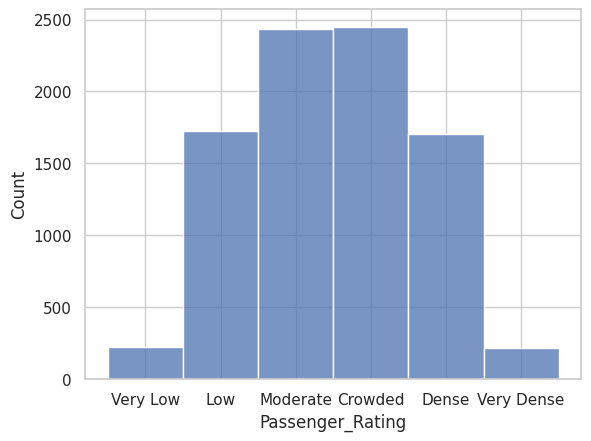

In [ ]:
sns.histplot(data=pk_df,x='Passenger_Rating')
plt.show()

## All organizations

In [ ]:
grouped_df = rated_df.copy()
grouped_df["Datetime"] = pd.to_datetime(grouped_df["Datetime"], format="%d/%m/%Y %H:%M")

agg_df = grouped_df.groupby("Datetime").agg({
    "temperature_c": "mean",
    "humidity": "mean",
    "pressure_mb": "mean",
    "Passenger_Count": "sum",
    "Time_Block": "first",
    "Day_of_Week": "first"
}).reset_index()

features = ["temperature_c", "humidity", "pressure_mb", "Time_Block", "Day_of_Week"]
agg_df = agg_df.dropna(subset=features + ["Passenger_Count"])

quantile_edges = [0.0, 0.02, 0.17, 0.5, 0.83, 0.98, 1.0]
quantiles = agg_df["Passenger_Count"].quantile(quantile_edges).values
overall_bins = np.unique(quantiles)
labels = ["Very Low", "Low", "Moderate", "Crowded", "Dense", "Very Dense"][:len(overall_bins) - 1]

agg_df["Passenger_Rating"] = pd.cut(
    agg_df["Passenger_Count"],
    bins=overall_bins,
    labels=labels,
    include_lowest=True
)

le_dict = {}
for col in ["Time_Block", "Day_of_Week"]:
    le = LabelEncoder()
    agg_df[col] = le.fit_transform(agg_df[col])
    le_dict[col] = le

target_le = LabelEncoder()
agg_df["Rating_Label"] = target_le.fit_transform(agg_df["Passenger_Rating"])

max_count = agg_df["Rating_Label"].value_counts().max()
resampled_df = pd.DataFrame()

for label in agg_df["Rating_Label"].unique():
    group = agg_df[agg_df["Rating_Label"] == label]
    resampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    resampled_df = pd.concat([resampled_df, resampled])

X = resampled_df[features]
y = resampled_df["Rating_Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)

for col in X_train.columns:
    X_test[col] = X_test[col].clip(upper=X_train[col].max())

model = CategoricalNB(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

              precision    recall  f1-score   support

     Crowded       0.39      0.40      0.39       954
       Dense       0.40      0.27      0.32       954
         Low       0.32      0.15      0.20       954
    Moderate       0.30      0.15      0.20       955
  Very Dense       0.51      0.76      0.61       955
    Very Low       0.40      0.73      0.51       954

    accuracy                           0.41      5726
   macro avg       0.39      0.41      0.37      5726
weighted avg       0.39      0.41      0.37      5726



In [ ]:
agg_df_c = agg_df.copy()
agg_df_c = agg_df_c.drop(columns=['Datetime'])

label_encoder = LabelEncoder()
agg_df_c['Time_Block'] = label_encoder.fit_transform(agg_df_c['Time_Block'])
agg_df_c['Day_of_Week'] = label_encoder.fit_transform(agg_df_c['Day_of_Week'])
agg_df_c['Passenger_Rating'] = agg_df_c['Passenger_Rating'].map(rating_map)

X = agg_df_c.drop(columns=['Passenger_Count','Rating_Label'])
y = agg_df_c['Passenger_Count']
X = X.apply(pd.to_numeric, errors='coerce')
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

quantile = 0.48
model = QuantReg(y_train, np.asarray(X_train_scaled))
result = model.fit(q=quantile)
print(result.summary())

y_pred = result.predict(np.asarray(X_test_scaled))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

                         QuantReg Regression Results                          
Dep. Variable:        Passenger_Count   Pseudo R-squared:               0.6978
Model:                       QuantReg   Bandwidth:                       766.4
Method:                 Least Squares   Sparsity:                    1.142e+04
Date:                Sun, 13 Apr 2025   No. Observations:                23104
Time:                        15:47:16   Df Residuals:                    23097
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.862e+04     37.542    762.310      0.000    2.85e+04    2.87e+04
x1           642.8086     61.837     10.395      0.000     521.605     764.013
x2           604.0406     56.324     10.724      0.000     493.641     714.440
x3           462.1518     47.688      9.691      0.0

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)
best_quantile = None
best_mse = float('inf')
for quantile in quantiles:
    model = QuantReg(y_train, np.asarray(X_train_scaled))
    result = model.fit(q=quantile)
    y_pred = result.predict(np.asarray(X_test_scaled))
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile
    print(f"Quantile: {quantile:.2f}, MSE: {mse:.2f}")
print(f"Best quantile: {best_quantile:.2f} with MSE: {best_mse:.2f}")

Quantile: 0.01, MSE: 83417442.72
Quantile: 0.02, MSE: 78058702.28
Quantile: 0.03, MSE: 73245963.79
Quantile: 0.04, MSE: 69215441.29
Quantile: 0.05, MSE: 65769349.26
Quantile: 0.06, MSE: 62985175.56
Quantile: 0.07, MSE: 60198469.39
Quantile: 0.08, MSE: 56077559.62
Quantile: 0.09, MSE: 52265907.56
Quantile: 0.10, MSE: 48483983.32
Quantile: 0.11, MSE: 44220678.33
Quantile: 0.12, MSE: 41935280.41
Quantile: 0.13, MSE: 39856801.04
Quantile: 0.14, MSE: 38131919.51
Quantile: 0.15, MSE: 36538827.66
Quantile: 0.16, MSE: 35183867.84
Quantile: 0.17, MSE: 33828062.22
Quantile: 0.18, MSE: 32412313.90
Quantile: 0.19, MSE: 31152412.22
Quantile: 0.20, MSE: 29873705.74


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.21, MSE: 28914376.97
Quantile: 0.22, MSE: 28068989.72
Quantile: 0.23, MSE: 27265296.32
Quantile: 0.24, MSE: 26411896.25
Quantile: 0.25, MSE: 25671179.20
Quantile: 0.26, MSE: 24966077.81
Quantile: 0.27, MSE: 24237848.49


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.28, MSE: 23536015.81
Quantile: 0.29, MSE: 22831699.55
Quantile: 0.30, MSE: 22214783.12
Quantile: 0.31, MSE: 21597295.29
Quantile: 0.32, MSE: 20962064.38
Quantile: 0.33, MSE: 20295617.95
Quantile: 0.34, MSE: 19723508.44
Quantile: 0.35, MSE: 19194307.63
Quantile: 0.36, MSE: 18738411.79
Quantile: 0.37, MSE: 18343567.61
Quantile: 0.38, MSE: 17984904.42
Quantile: 0.39, MSE: 17663035.91
Quantile: 0.40, MSE: 17371991.98
Quantile: 0.41, MSE: 17121138.42
Quantile: 0.42, MSE: 16906581.42
Quantile: 0.43, MSE: 16687922.20
Quantile: 0.44, MSE: 16538213.07
Quantile: 0.45, MSE: 16437410.67
Quantile: 0.46, MSE: 16361970.50
Quantile: 0.47, MSE: 16317528.44
Quantile: 0.48, MSE: 16306203.94
Quantile: 0.49, MSE: 16323218.00
Quantile: 0.50, MSE: 16364397.66
Quantile: 0.51, MSE: 16437785.75
Quantile: 0.52, MSE: 16536252.62
Quantile: 0.53, MSE: 16660479.64
Quantile: 0.54, MSE: 16837042.62
Quantile: 0.55, MSE: 17036925.51
Quantile: 0.56, MSE: 17254997.43
Quantile: 0.57, MSE: 17504684.33
Quantile: 

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.80, MSE: 33158411.04
Quantile: 0.81, MSE: 34462092.72
Quantile: 0.82, MSE: 35771048.04
Quantile: 0.83, MSE: 36841761.73
Quantile: 0.84, MSE: 37836553.65
Quantile: 0.85, MSE: 38888144.28
Quantile: 0.86, MSE: 40188322.08
Quantile: 0.87, MSE: 41435573.58
Quantile: 0.88, MSE: 42821634.26
Quantile: 0.89, MSE: 44212759.16


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.90, MSE: 45695952.44
Quantile: 0.91, MSE: 47498428.74
Quantile: 0.92, MSE: 49129577.82
Quantile: 0.93, MSE: 51162434.24
Quantile: 0.94, MSE: 53830955.84
Quantile: 0.95, MSE: 56189824.29
Quantile: 0.96, MSE: 58830107.36
Quantile: 0.97, MSE: 61567650.06
Quantile: 0.98, MSE: 64520407.27
Quantile: 0.99, MSE: 68154762.80
Best quantile: 0.48 with MSE: 16306203.94


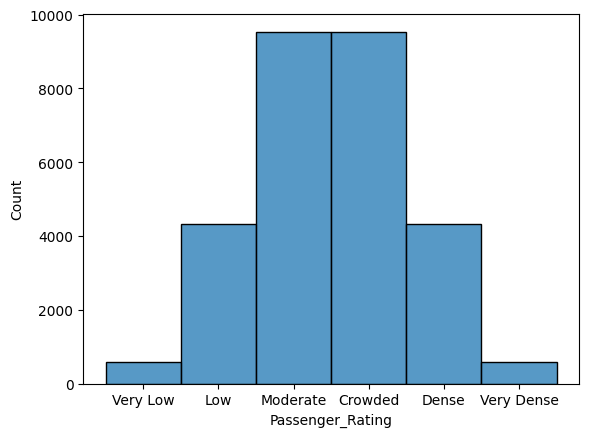

In [ ]:
sns.histplot(data=agg_df,x='Passenger_Rating')
plt.show()